# Berater Environment v13

## Changes from v12 (work in progress)
* migration to easyagents
* Max. number of steps management and debug logging migrated to easyagents.TrainingDuration
* render yields the last step, supporting modes 'ansi' and 'human', 

### Install gym, tensorflow, tf-agents,...

In [45]:
!pip install easyagents > /dev/null

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


# Define Gym Environment

### Imports

In [46]:
import numpy as np
import random
import gym
from gym.utils import seeding
from gym import spaces

import pdb

### Helper methods

In [47]:
def state_name_to_int(state):
    state_name_map = {
        'S': 0,
        'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7,
        'H': 8,
        'K': 9,
        'L': 10,
        'M': 11,
        'N': 12,
        'O': 13
    }
    return state_name_map[state]

def int_to_state_name(state_as_int):
    state_map = {
        0: 'S',
        1: 'A',
        2: 'B',
        3: 'C',
        4: 'D',
        5: 'E',
        6: 'F',
        7: 'G',
        8: 'H',
        9: 'K',
        10: 'L',
        11: 'M',
        12: 'N',
        13: 'O'
    }
    return state_map[state_as_int]
    


### Berater Environment (OpenAI Gym)

In [48]:
class BeraterEnv(gym.Env):
    """
    The Berater Problem

    Actions:
    There are 4 discrete deterministic actions, each choosing one direction
    """
    metadata = {'render.modes': ['ansi']}
    showStep = False

    def __init__(self):
        #         self.map = {
        #             'S': [('A', 100), ('B', 400), ('C', 200 )],
        #             'A': [('B', 250), ('C', 400), ('S', 100 )],
        #             'B': [('A', 250), ('C', 250), ('S', 400 )],
        #             'C': [('A', 400), ('B', 250), ('S', 200 )]
        #         }
        self.map = {
            'S': [('A', 300), ('B', 100), ('C', 200)],
            'A': [('S', 300), ('B', 100), ('E', 100), ('D', 100)],
            'B': [('S', 100), ('A', 100), ('C', 50), ('K', 200)],
            'C': [('S', 200), ('B', 50), ('M', 100), ('L', 200)],
            'D': [('A', 100), ('F', 50)],
            'E': [('A', 100), ('F', 100), ('H', 100)],
            'F': [('D', 50), ('E', 100), ('G', 200)],
            'G': [('F', 200), ('O', 300)],
            'H': [('E', 100), ('K', 300)],
            'K': [('B', 200), ('H', 300)],
            'L': [('C', 200), ('M', 50)],
            'M': [('C', 100), ('L', 50), ('N', 100)],
            'N': [('M', 100), ('O', 100)],
            'O': [('N', 100), ('G', 300)]
        }
        max_paths = 4
        self.action_space = spaces.Discrete(max_paths)

        positions = len(self.map)
        # observations: position, reward of all 4 local paths, rest reward of all locations
        # non existing path is -1000 and no position change
        # look at what #getObservation returns if you are confused
        low = np.append(np.append([0], np.full(max_paths, -1000)), np.full(positions, 0))
        high = np.append(np.append([positions - 1], np.full(max_paths, 1000)), np.full(positions, 1000))
        self.observation_space = spaces.Box(low=low,
                                            high=high,
                                            dtype=np.float32)
        self.reward_range = (-1, 1)
        self.envEpisodeCount = 0
        self.envStepCount = 0

        self.reset()
        self.optimum = self.calculate_customers_reward()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def iterate_path(self, state, action):
        paths = self.map[state]
        if action < len(paths):
            return paths[action]
        else:
            # sorry, no such action, stay where you are and pay a high penalty
            return (state, 1000)

    def step(self, action):
        destination, cost = self.iterate_path(self.state, action)

        self.cost = cost
        self.action=action
        self.lastStep_state = self.state
        self.state = destination
        self.customerReward = self.customer_reward[destination]
        self.reward = 0
        self.reward = (self.customerReward - self.cost) / self.optimum

        self.customer_visited(destination)
        done = (destination == 'S' and self.all_customers_visited())

        stateAsInt = state_name_to_int(self.state)
        self.totalReward += self.reward
        self.stepCount += 1
        self.envStepCount += 1

        if done and not self.isDone:
            self.envEpisodeCount += 1

        self.isDone = done
        observation = self.getObservation(stateAsInt)
        info = {"from": self.state, "to": destination}
        return observation, self.reward, done, info

    def getObservation(self, position):
        result = np.array([position,
                           self.getPathObservation(position, 0),
                           self.getPathObservation(position, 1),
                           self.getPathObservation(position, 2),
                           self.getPathObservation(position, 3)
                           ],
                          dtype=np.float32)
        all_rest_rewards = list(self.customer_reward.values())
        result = np.append(result, all_rest_rewards)
        return result

    def getPathObservation(self, position, path):
        paths = self.map[self.state]
        if path < len(paths):
            target, cost = paths[path]
            reward = self.customer_reward[target]
            result = reward - cost
        else:
            result = -1000

        return result

    def customer_visited(self, customer):
        self.customer_reward[customer] = 0

    def all_customers_visited(self):
        return self.calculate_customers_reward() == 0

    def calculate_customers_reward(self):
        sum = 0
        for value in self.customer_reward.values():
            sum += value
        return sum

    def modulate_reward(self):
        number_of_customers = len(self.map) - 1
        number_per_consultant = int(number_of_customers / 2)
        self.customer_reward = {
            'S': 0
        }
        for customer_nr in range(1, number_of_customers + 1):
            self.customer_reward[int_to_state_name(customer_nr)] = 0

        # every consultant only visits a few random customers
        samples = random.sample(range(1, number_of_customers + 1), k=number_per_consultant)
        key_list = list(self.customer_reward.keys())
        for sample in samples:
            self.customer_reward[key_list[sample]] = 1000

    def reset(self):
        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False
        self.state = ''
        self.cost = 0
        self.action=0
        self.lastStep_state = ''
        self.customerReward = 0
        self.reward = 0

        self.envEpisodeCount += 1

        self.modulate_reward()
        self.state = 'S'
        return self.getObservation(state_name_to_int(self.state))


    def render(self, mode='human'):
        msg=("Episode: " + ("%4.0f  " % self.envEpisodeCount) +
              " Step: " + ("%4.0f  " % self.stepCount) +
              self.lastStep_state + ' --' + str(self.action) + '-> ' + self.state +
              ' R=' + ("% 2.2f" % self.reward) + ' totalR=' + ("% 3.2f" % self.totalReward) +
              ' cost=' + ("%4.0f" % self.cost) + ' customerR=' + ("%4.0f" % self.customerReward) + ' optimum=' + (
                          "%4.0f" % self.optimum)
             )
        if mode == 'ansi':
            return msg
        elif mode is 'human':
            print(msg)
        else:
            super().render(mode=mode)

### Register with OpenAI Gym

In [49]:
if not 'isEnvRegistered' in locals():
  env_name="Berater-v1"
  gym.envs.registration.register(id=env_name,entry_point=BeraterEnv,max_episode_steps=1000)
  isEnvRegistered=True
  print("Berater registered as '" + env_name + "'")
else:
  print("Already registered")

Already registered


# Train policy with tfagents PpoAgent

## Install

In [50]:
!pip install easyagents > /dev/null


You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [51]:
import sys

if 'google.colab' in sys.modules:
    !apt-get install xvfb >/dev/null
    !pip install pyvirtualdisplay >/dev/null    
    
    from pyvirtualdisplay import Display
    Display(visible=0, size=(960, 720)).start()  

##  Dry run (short training, no logging)

In [52]:
from easyagents.tfagents import PpoAgent
from easyagents.config import TrainingDurationFast
from easyagents.config import LoggingSilent

In [53]:
ppoAgent = PpoAgent(    gym_env_name = 'Berater-v1',                        
                        training_duration=TrainingDurationFast(),
                        logging=LoggingSilent())
ppoAgent.train()

### Visualize

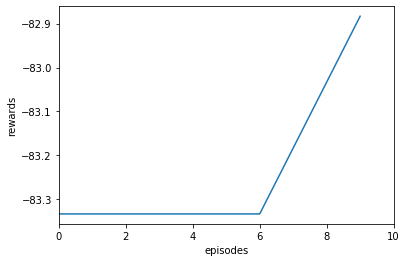

In [22]:
ppoAgent.plot_average_rewards()

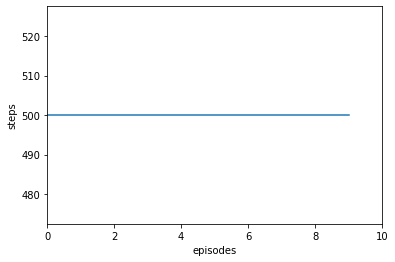

In [23]:
ppoAgent.plot_average_steps()

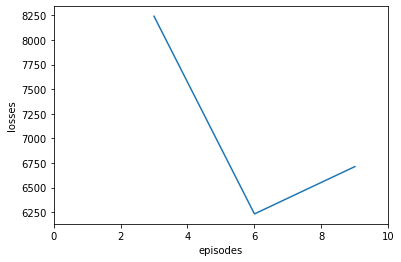

In [24]:
ppoAgent.plot_losses()

In [26]:
!pip install pyvis

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [29]:
from pyvis.network import Network

g = Network()
g.add_nodes([1,2,3], value=[10, 100, 400], title=["I am node 1", "node 2 here", "and im node 3"], 
            x=[21.4, 54.2, 11.2], y=[100.2, 23.54, 32.1], 
            label=["NODE 1", "NODE 2", "NODE 3"], 
            color=["#00ff1e", "#162347", "#dd4b39"])

In [ ]:
net = Network()
net.add_node(1, label="Node 1") # node id = 1 and label = Node 1
net.add_node(2) 
nodes = ["a", "b", "c", "d"]
net.add_nodes(nodes) # node ids and labels = ["a", "b", "c", "d"]
net.add_nodes("hello") # node ids and labels = ["h", "e", "l", "o"]

In [30]:
!pip install pandas

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [39]:
from pyvis.network import Network
import pandas as pd

got_net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", notebook=True)

# set the physics layout of the network
got_net.barnes_hut()
got_data = pd.read_csv("https://www.macalester.edu/~abeverid/data/stormofswords.csv")

sources = got_data['Source']
targets = got_data['Target']
weights = got_data['Weight']

edge_data = zip(sources, targets, weights)

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]

    got_net.add_node(src, src, title=src)
    got_net.add_node(dst, dst, title=dst)
    got_net.add_edge(src, dst, value=w)

neighbor_map = got_net.get_adj_list()

# add neighbor data to node hover data
for node in got_net.nodes:
    node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
    node["value"] = len(neighbor_map[node["id"]])

got_net.show("gameofthrones.html")

In [40]:
got_net.show_buttons()
got_net.show("got_net.html")

In [85]:
b = BeraterEnv()
n = Network(height="750px", width="100%",notebook=True)
for node in b.map.keys():
    reward = (b.customer_reward[node] / 100) + 10
    n.add_node(node,value=reward)
n.add_nodes(b.map.keys())
for source, connections in b.map.items():
    for target, cost in connections:
        n.add_edge(source,target, value=400-cost)

In [73]:

n.show("kuckuck.html")


dict_keys

In [99]:
n.nodes


[{'value': 10.0, 'id': 'S', 'label': 'S', 'shape': 'dot'},
 {'value': 20.0, 'id': 'A', 'label': 'A', 'shape': 'dot'},
 {'value': 20.0, 'id': 'B', 'label': 'B', 'shape': 'dot'},
 {'value': 10.0, 'id': 'C', 'label': 'C', 'shape': 'dot'},
 {'value': 20.0, 'id': 'D', 'label': 'D', 'shape': 'dot'},
 {'value': 10.0, 'id': 'E', 'label': 'E', 'shape': 'dot'},
 {'value': 20.0, 'id': 'F', 'label': 'F', 'shape': 'dot'},
 {'value': 20.0, 'id': 'G', 'label': 'G', 'shape': 'dot'},
 {'value': 10.0, 'id': 'H', 'label': 'H', 'shape': 'dot'},
 {'value': 20.0, 'id': 'K', 'label': 'K', 'shape': 'dot'},
 {'value': 10.0, 'id': 'L', 'label': 'L', 'shape': 'dot'},
 {'value': 10.0, 'id': 'M', 'label': 'M', 'shape': 'dot'},
 {'value': 10.0, 'id': 'N', 'label': 'N', 'shape': 'dot'},
 {'value': 10.0, 'id': 'O', 'label': 'O', 'shape': 'dot'}]

In [142]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
for node in b.map.keys():
    if b.customer_reward[node] > 0:
        color='yellowgreen'
    else: color='darkgoldenrod'
    G.add_node(node, color=color)    
for source, connections in b.map.items():
    for target, cost in connections:
        if cost >= 300:
            color='dodgerblue'
        elif cost >= 200:
            color='darkgoldenrod'
        elif cost >= 100:
            color='forestgreen'
        else:
            color='greenyellow'
        G.add_edge(source,target,color=color,weight=(400-cost)/50 + 1)

edges = G.edges()
edge_colors = [G[u][v]['color'] for u,v in edges]
edge_weights = [G[u][v]['weight'] for u,v in edges]


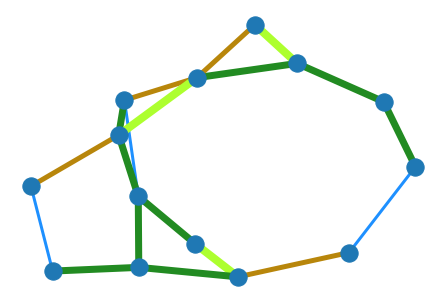

In [204]:
nx.planar_layout(g)
nx.draw(G, edges=edges, edge_color=edge_colors, width=edge_weights)